In [1]:
# standard packages 
import pandas as pd 
import numpy as np 
import os 
import itertools

# visuals 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 



#statistics 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# balancing the model 
from imblearn.over_sampling import SMOTE 
from sklearn.feature_selection import RFE

#accuracy of model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score,roc_curve,classification_report


import warnings 
warnings.filterwarnings("ignore")



# Load Data

In [2]:
file = 'Desktop/US_Accidents_Dec21_updated.csv.zip'
# to search for missing values 
missing_values = ['N/A', 'NA', 'None', 'n/a', 'na', 'nAn', 'NaN', '-', '.', ' ']

# parse through Start and End 
df = pd.read_csv(file, compression='zip', na_values=missing_values, parse_dates=['Start_Time','End_Time'])

df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [3]:
# add Time Columns 
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Hour'] = df['Start_Time'].dt.hour
df['Day'] = df['Start_Time'].dt.weekday

In [4]:
# convert to string 
df['Month'] = df['Month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],
                                 ['January', 'February', 'March', 'April', 'May',
                                 'June', 'July', 'August', 'September', 
                                 'October', 'November', 'December'])
df['Day'] = df['Start_Time'].dt.day_name()

# Explore Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 51 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [6]:
df.shape

(2845342, 51)

In [7]:
# look at continuous types 
print('Continuous Features')
df.select_dtypes(include='number').T

Continuous Features


,0,1,2,3,4,5,6,7,8,9,...,2845332,2845333,2845334,2845335,2845336,2845337,2845338,2845339,2845340,2845341
Severity,3.00000,2.00000,2.00000,2.00000,3.000000,2.00000,2.00000,2.00000,2.000000,2.00000,...,2.00000,2.000000,2.00000,2.00000,2.000000,2.00000,2.00000,2.00000,2.00000,2.00000
Start_Lat,40.10891,39.86542,39.10266,41.06213,39.172393,39.06324,39.77565,41.37531,40.702247,40.10931,...,34.06446,33.943599,34.26103,33.74170,34.239104,34.00248,32.76696,33.77545,33.99246,34.13393
Start_Lng,-83.09286,-84.06280,-84.52468,-81.53784,-84.492792,-84.03243,-84.18603,-81.82017,-84.075887,-82.96849,...,-118.00388,-117.077880,-119.22800,-117.83709,-118.416176,-117.37936,-117.14806,-117.84779,-118.40302,-117.23092
End_Lat,40.11206,39.86501,39.10209,41.06217,39.170476,39.06731,39.77275,41.36786,40.699110,40.11078,...,34.06533,33.943599,34.26239,33.73917,34.239104,33.99888,32.76555,33.77740,33.98311,34.13736
End_Lng,-83.03187,-84.04873,-84.52396,-81.53547,-84.501798,-84.05851,-84.18805,-81.82174,-84.084293,-82.98400,...,-117.99715,-117.077880,-119.23087,-117.83001,-118.416176,-117.37094,-117.15363,-117.85727,-118.39565,-117.23934
Distance(mi),3.23000,0.74700,0.05500,0.12300,0.500000,1.42700,0.22700,0.52100,0.491000,0.82600,...,0.39000,0.000000,0.18900,0.44300,0.000000,0.54300,0.33800,0.56100,0.77200,0.53700
Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature(F),42.10000,36.90000,36.00000,39.00000,37.000000,35.60000,33.80000,33.10000,39.000000,32.00000,...,78.00000,88.000000,73.00000,75.00000,81.000000,86.00000,70.00000,73.00000,71.00000,79.00000
Wind_Chill(F),36.10000,NaN,NaN,NaN,29.800000,29.20000,NaN,30.00000,31.800000,28.70000,...,78.00000,88.000000,73.00000,75.00000,81.000000,86.00000,70.00000,73.00000,71.00000,79.00000
Humidity(%),58.00000,91.00000,97.00000,55.00000,93.000000,100.00000,100.00000,92.00000,70.000000,100.00000,...,52.00000,32.000000,68.00000,60.00000,48.000000,40.00000,73.00000,64.00000,81.00000,47.00000


In [8]:
# look at categorical types 
print('Categorical Features')
df.select_dtypes(include='object').T

Categorical Features


,0,1,2,3,4,5,6,7,8,9,...,2845332,2845333,2845334,2845335,2845336,2845337,2845338,2845339,2845340,2845341
ID,A-1,A-2,A-3,A-4,A-5,A-6,A-7,A-8,A-9,A-10,...,A-2845333,A-2845334,A-2845335,A-2845336,A-2845337,A-2845338,A-2845339,A-2845340,A-2845341,A-2845342
Description,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,At OH-4/OH-235/Exit 41 - Accident.,At I-71/US-50/Exit 1 - Accident.,At Dart Ave/Exit 21 - Accident.,At Mitchell Ave/Exit 6 - Accident.,At Dela Palma Rd - Accident.,At OH-4/Exit 54 - Accident.,At Bagley Rd/Exit 235 - Accident.,At OH-65/Exit 122 - Accident.,At I-71/Exit 26 - Accident.,...,At I-605 - Accident.,At Jack Rabbit Trl - Accident.,At Telephone Rd/Exit 65 - Accident.,At CA-55 - Accident.,At Osborne St/Exit 154 - Accident.,At Market St - Accident.,At Camino Del Rio/Mission Center Rd - Accident.,At Glassell St/Grand Ave - Accident. in the ri...,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,At Highland Ave/Arden Ave - Accident.
Street,Outerbelt E,I-70 E,I-75 S,I-77 N,I-75 S,State Route 32,I-75 S,I-71 S,E Hanthorn Rd,Outerbelt W,...,I-10 E,CA-60 E,El Camino Real N,Santa Ana Fwy S,Golden State Fwy N,Pomona Fwy E,I-8 W,Garden Grove Fwy,San Diego Fwy S,CA-210 W
Side,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,R
City,Dublin,Dayton,Cincinnati,Akron,Cincinnati,Williamsburg,Dayton,Cleveland,Lima,Westerville,...,Baldwin Park,Moreno Valley,Ventura,Tustin,Pacoima,Riverside,San Diego,Orange,Culver City,Highland
County,Franklin,Montgomery,Hamilton,Summit,Hamilton,Clermont,Montgomery,Cuyahoga,Allen,Franklin,...,Los Angeles,Riverside,Ventura,Orange,Los Angeles,Riverside,San Diego,Orange,Los Angeles,San Bernardino
State,OH,OH,OH,OH,OH,OH,OH,OH,OH,OH,...,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA
Zipcode,43017,45424,45203,44311,45217,45176,45404,44130,45806,43081,...,91706,92555,93003,92780,91331,92501,92108,92866,90230,92346
Country,US,US,US,US,US,US,US,US,US,US,...,US,US,US,US,US,US,US,US,US,US
Timezone,US/Eastern,US/Eastern,US/Eastern,US/Eastern,US/Eastern,US/Eastern,US/Eastern,US/Eastern,US/Eastern,US/Eastern,...,US/Pacific,US/Pacific,US/Pacific,US/Pacific,US/Pacific,US/Pacific,US/Pacific,US/Pacific,US/Pacific,US/Pacific


In [9]:
# check to see if any columns are duplicated 
df.columns.duplicated().any()

False

In [10]:
# check for missing values based off of list of missing values
df.isna().any()

ID                       False
Severity                 False
Start_Time               False
End_Time                 False
Start_Lat                False
Start_Lng                False
End_Lat                  False
End_Lng                  False
Distance(mi)             False
Description              False
Number                    True
Street                    True
Side                     False
City                      True
County                   False
State                    False
Zipcode                   True
Country                  False
Timezone                  True
Airport_Code              True
Weather_Timestamp         True
Temperature(F)            True
Wind_Chill(F)             True
Humidity(%)               True
Pressure(in)              True
Visibility(mi)            True
Wind_Direction            True
Wind_Speed(mph)           True
Precipitation(in)         True
Weather_Condition         True
Amenity                  False
Bump                     False
Crossing

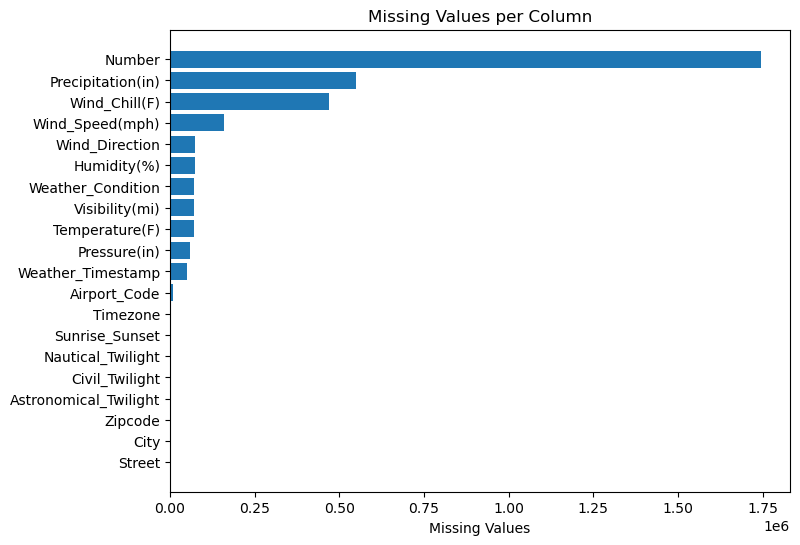

In [11]:
# look at number of missing values in each column 

missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(8,6))
rects = ax.barh(ind,missing_df.missing_count.values)
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing Values")
ax.set_title("Missing Values per Column")
plt.show()

In [12]:
# look at sum of unique values for each columns 
df.nunique(axis=0)

ID                       2845342
Severity                       4
Start_Time               1807311
End_Time                 2239983
Start_Lat                1093618
Start_Lng                1120365
End_Lat                  1080811
End_Lng                  1105404
Distance(mi)               14165
Description              1174563
Number                     46402
Street                    159651
Side                           3
City                       11681
County                      1707
State                         49
Zipcode                   363085
Country                        1
Timezone                       4
Airport_Code                2004
Weather_Timestamp         474214
Temperature(F)               788
Wind_Chill(F)                897
Humidity(%)                  100
Pressure(in)                1068
Visibility(mi)                76
Wind_Direction                24
Wind_Speed(mph)              136
Precipitation(in)            230
Weather_Condition            127
Amenity   

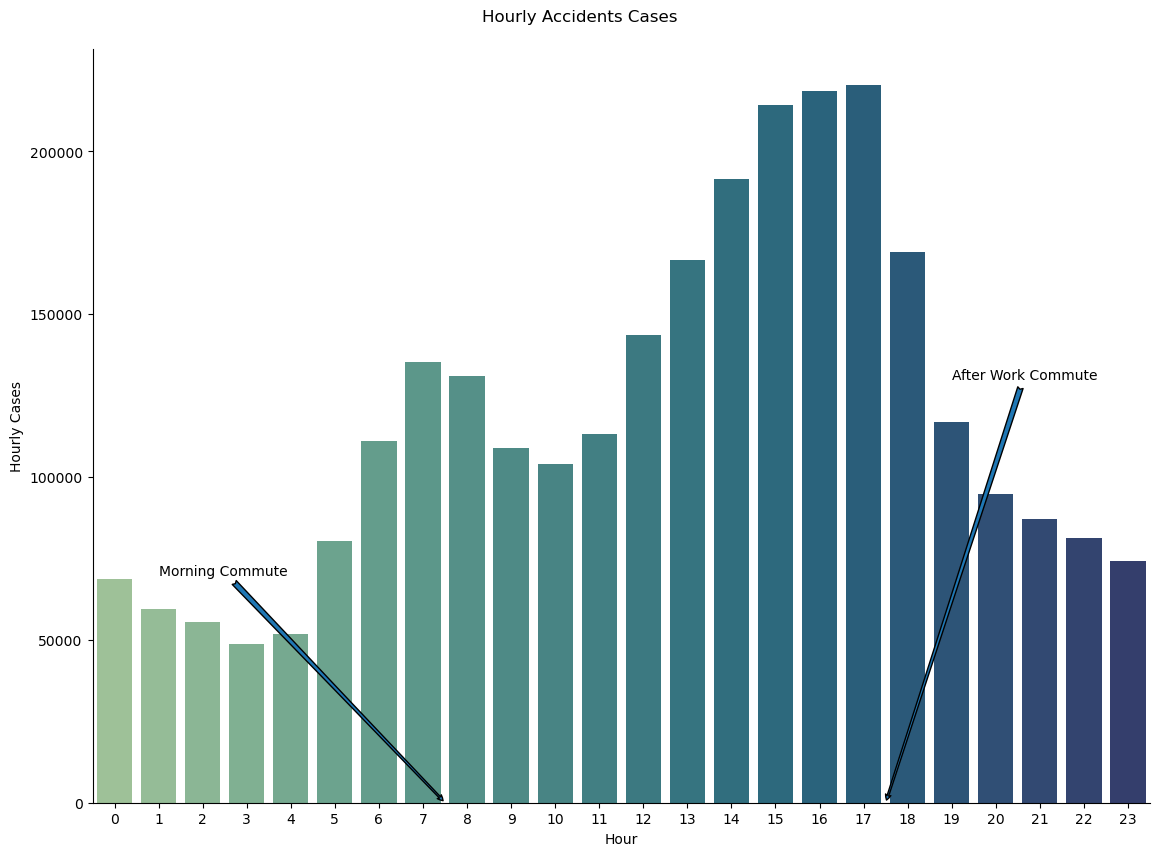

In [13]:
# accidents by hour
# point out standard morning and night rush 
h = sns.catplot(x='Hour',data=df, kind='count', height=8.27, aspect=11.7/8.27, palette='crest')
h.fig.suptitle('Hourly Accidents Cases', y=1.03)
h.set(ylabel='Hourly Cases', xlabel='Hour')
plt.annotate('Morning Commute', xy=(7.5,0), xytext=(1, 70000), arrowprops={'arrowstyle':'fancy'})
plt.annotate('After Work Commute', xy=(17.5,0), xytext=(19, 130000), arrowprops={'arrowstyle':'fancy'})
plt.show()

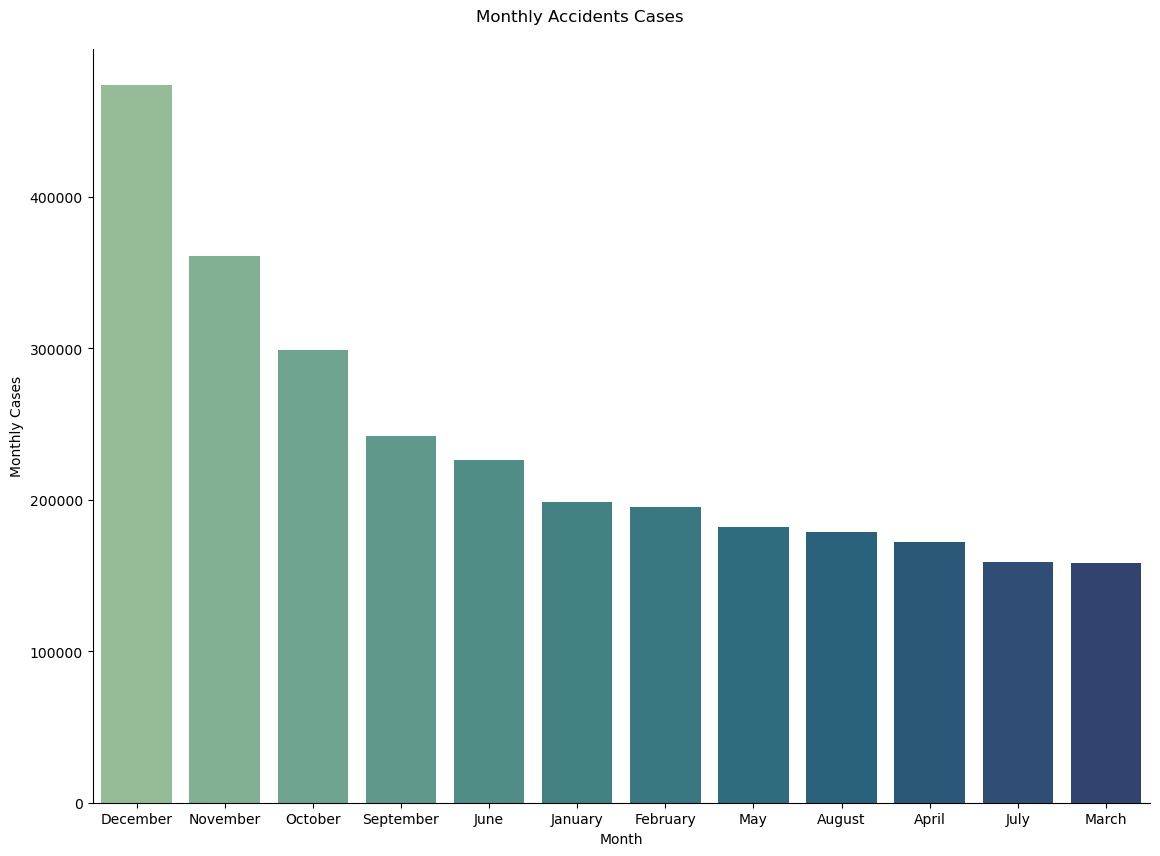

In [14]:
# monthly accidents, decending 
h = sns.catplot(x='Month',data=df, kind='count', order=df.Month.value_counts().index, height=8.27, aspect=11.7/8.27, palette='crest')
h.fig.suptitle('Monthly Accidents Cases', y=1.03)
h.set(ylabel='Monthly Cases', xlabel='Month')
plt.show()

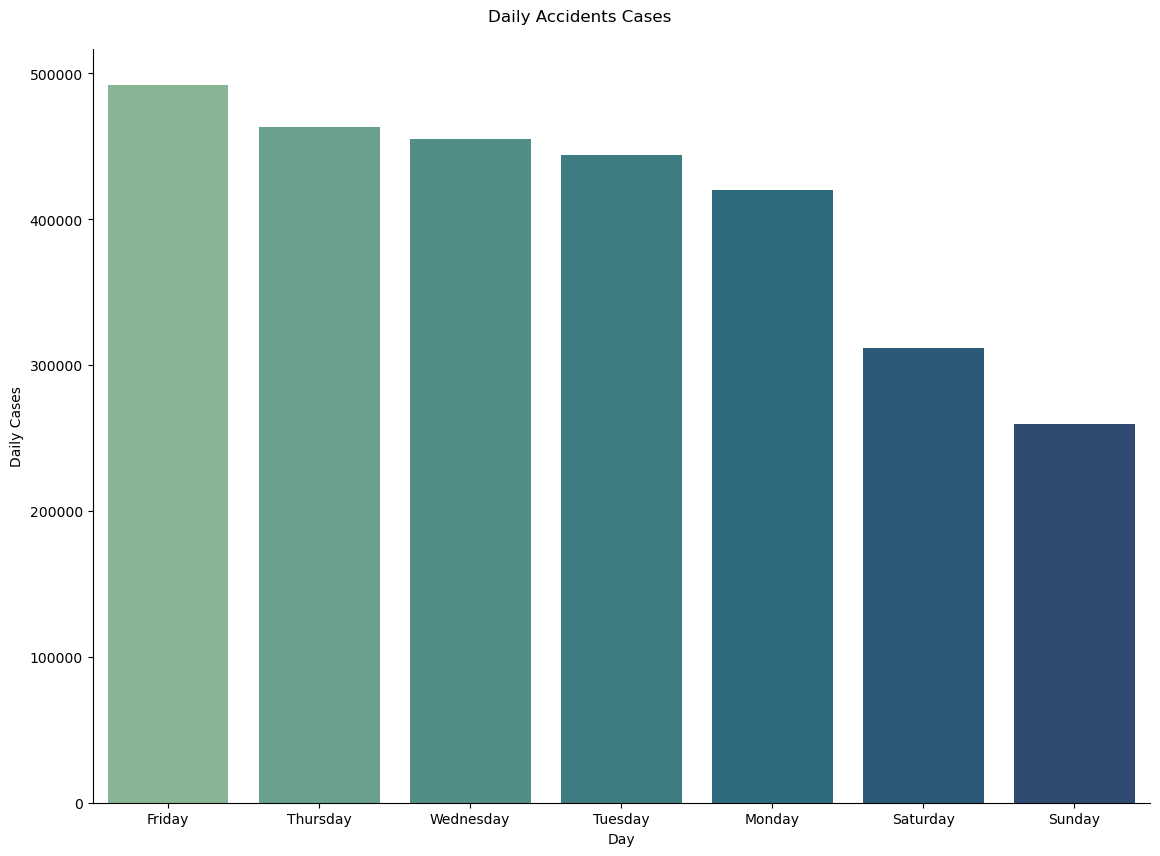

In [15]:
# daily accidents descending 
h = sns.catplot(x='Day',data=df, kind='count', order=df.Day.value_counts().index, height=8.27, aspect=11.7/8.27, palette='crest')
h.fig.suptitle('Daily Accidents Cases', y=1.03)
h.set(ylabel='Daily Cases', xlabel='Day')
plt.show()

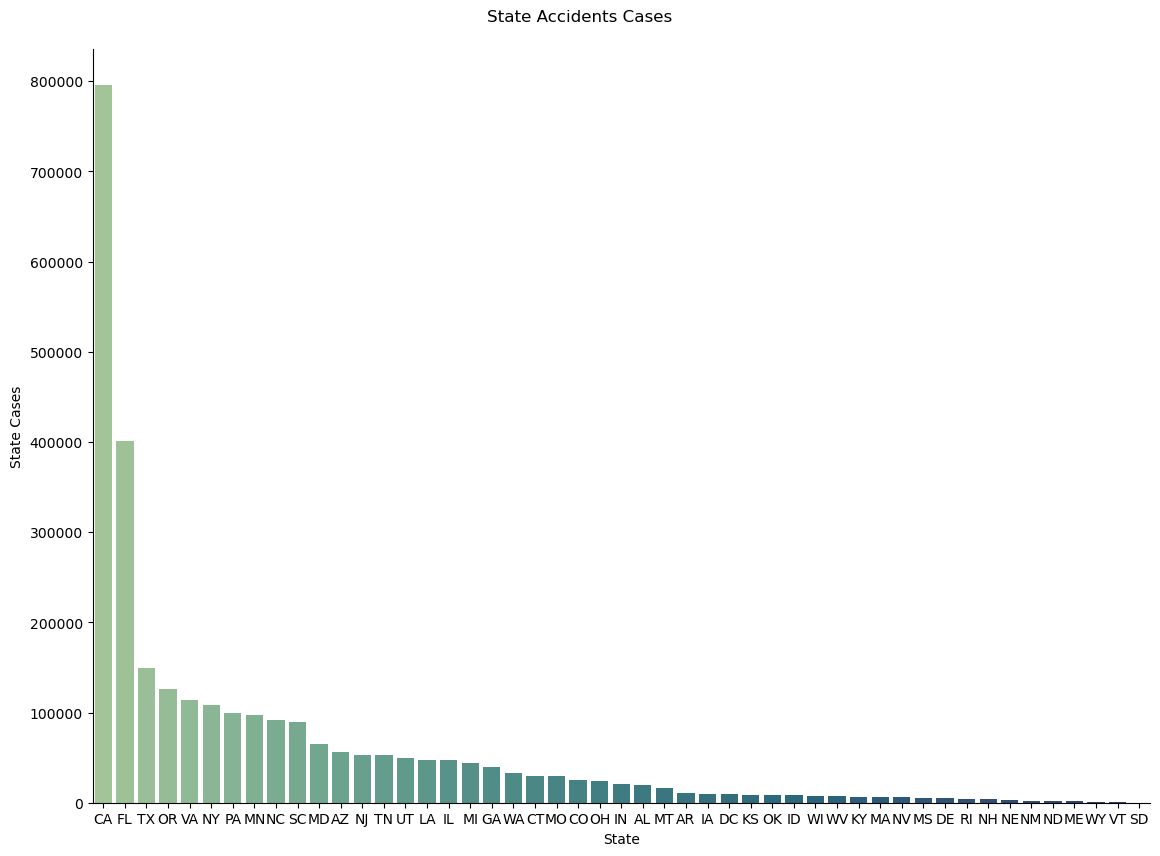

In [16]:
# descending accidents by state 
h = sns.catplot(x='State',data=df, kind='count', order=df.State.value_counts().index, height=8.27, aspect=11.7/8.27, palette='crest')
h.fig.suptitle('State Accidents Cases', y=1.03)
h.set(ylabel='State Cases', xlabel='State')
plt.show()

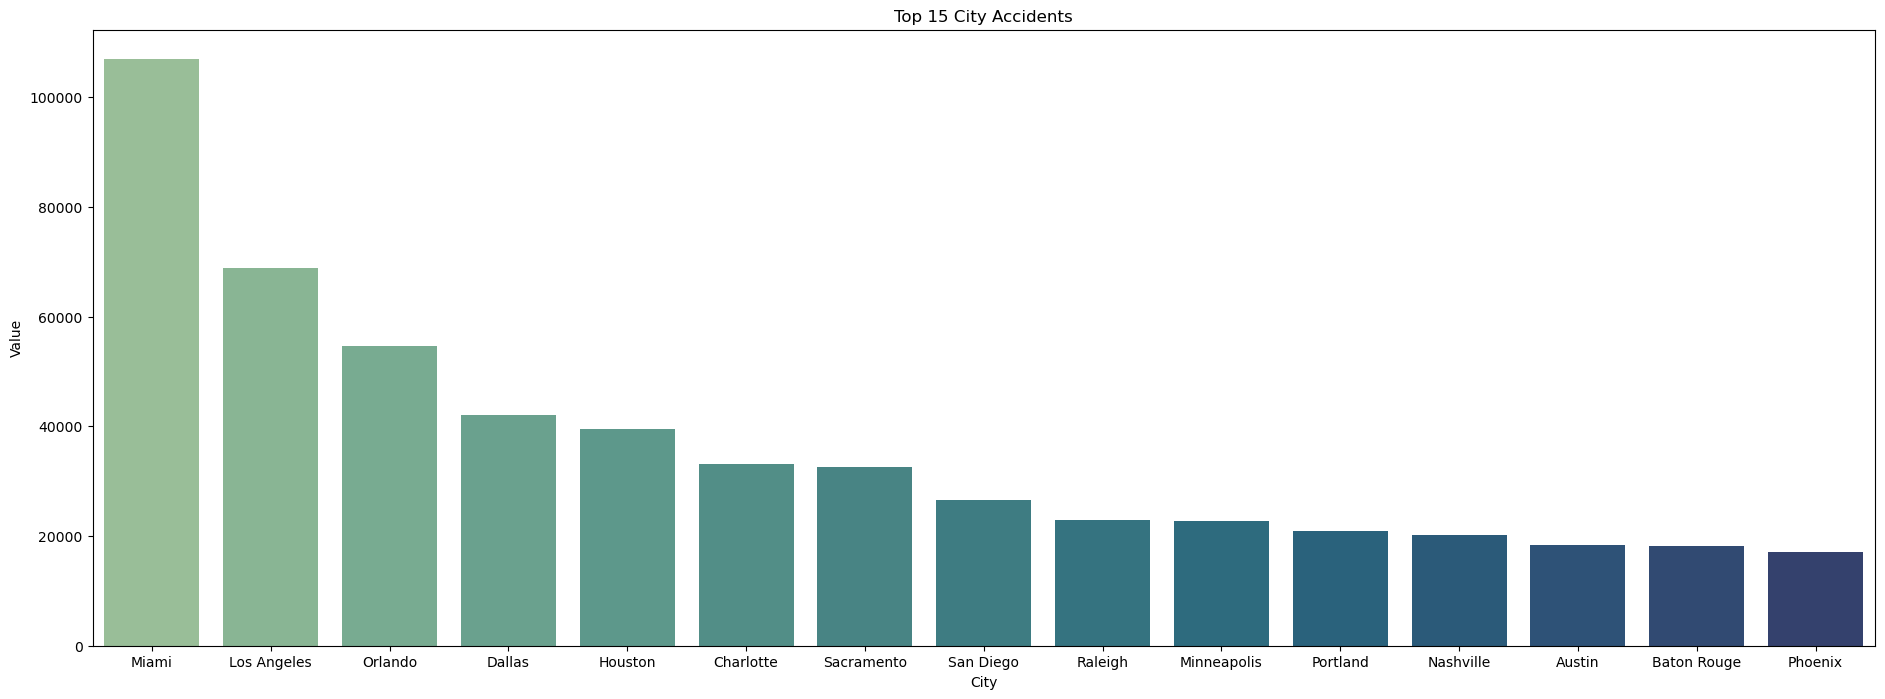

In [17]:
# descending accidents by city 
counts = df["City"].value_counts()[:15]
plt.figure(figsize=(23,8))
sns.barplot(counts.index, counts.values, palette='crest')
plt.title("Top 15 City Accidents")
plt.xlabel("City")
plt.ylabel("Value")
plt.show()

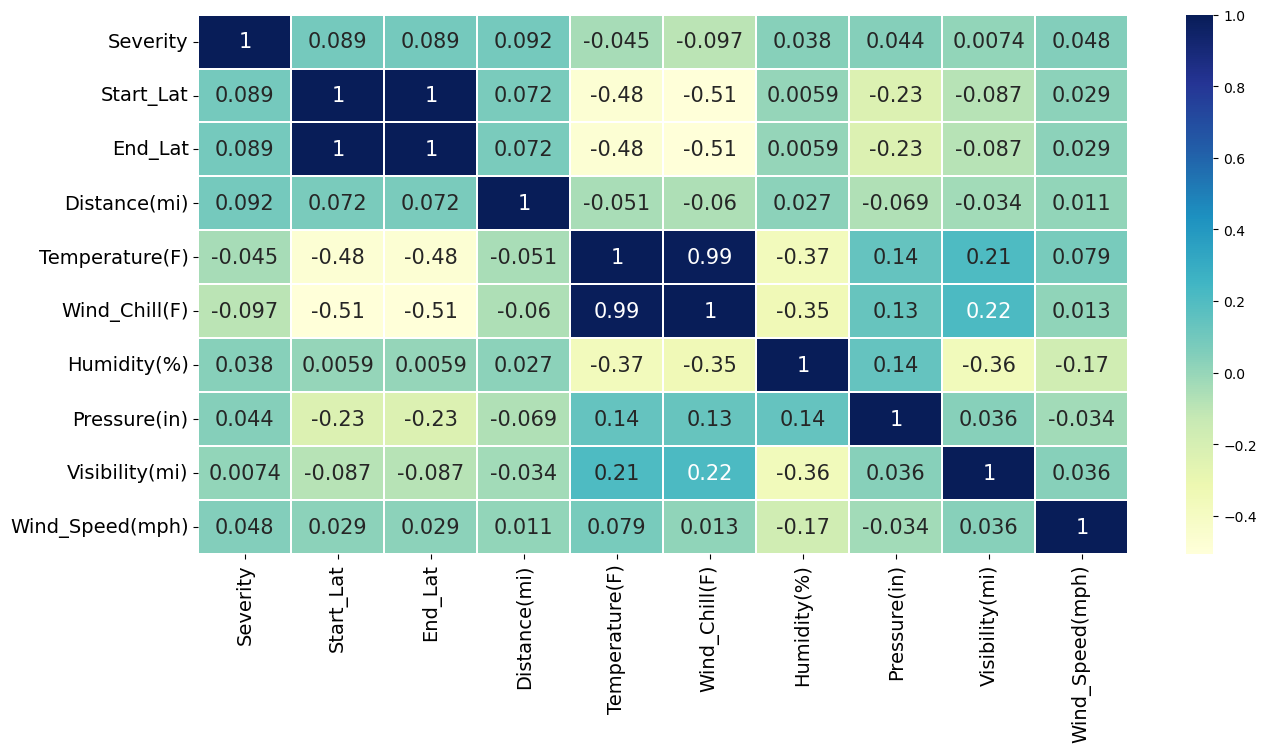

In [18]:
# heat map of accidents and severity by weather conditions 
fig=sns.heatmap(df[['Severity','Start_Lat','End_Lat','Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']].corr(),annot=True,cmap='YlGnBu',linewidths=0.2,annot_kws={'size':15})
fig=plt.gcf()
fig.set_size_inches(15,7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

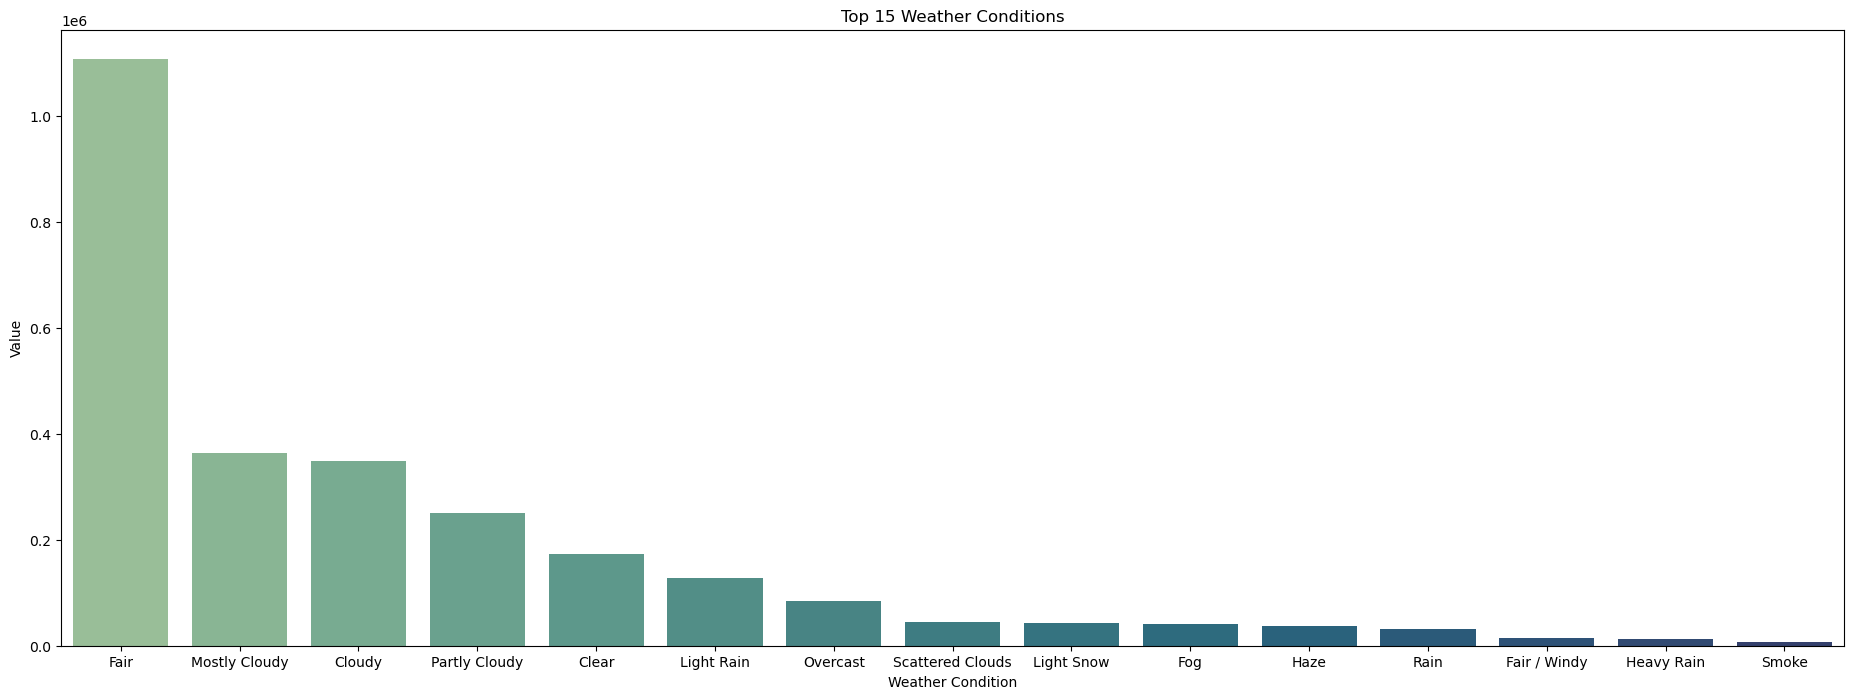

In [19]:
# top 15 weather conditions of Accidents 
counts = df["Weather_Condition"].value_counts()[:15]
plt.figure(figsize=(23,8))
sns.barplot(counts.index, counts.values, palette='crest')
plt.title("Top 15 Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Value")
plt.show()

# Cleaning Data

In [20]:
print('Shape before dropna()', df.shape)

df = df.dropna()

print('Shape after drapna()', df.shape)

Shape before dropna() (2845342, 51)
Shape after drapna() (943318, 51)


In [21]:
# split highways from local roads 
def str_type(text):
    if '-' in text or 'Fwy'in text or 'Expy' in text or 'Highway'in text or 'Hwy'in text :
        result = 'Highway'
    else:
        result = 'Local Streets'
    return result

df['Street'] = df['Street'].apply(str_type)

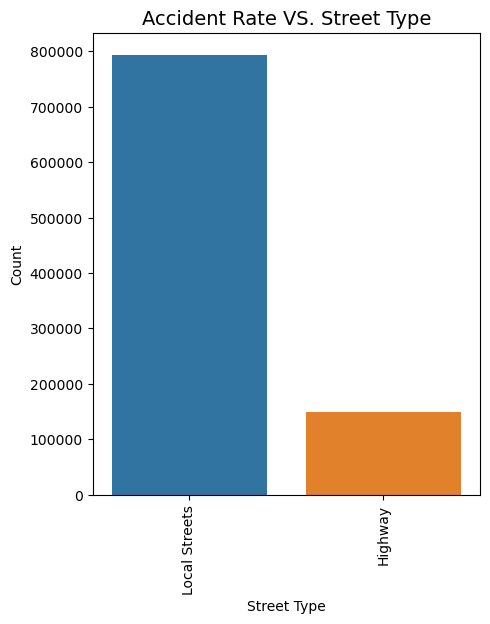

In [22]:
# plot data 
fig, ax = plt.subplots(figsize = (5, 6))
e = sns.countplot(x ='Street', data = df)
e.set_title('Accident Rate VS. Street Type', fontsize=14)
plt.xticks(rotation = 90)

plt.xlabel("Street Type")
plt.ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
plt.show();

In [23]:
# look at all values in weather condition 
weather_list = df['Weather_Condition'].values.tolist()
list(set(weather_list))

['Light Blowing Snow',
 'Drizzle and Fog',
 'Heavy Rain / Windy',
 'Wintry Mix / Windy',
 'Blowing Snow / Windy',
 'Wintry Mix',
 'Widespread Dust / Windy',
 'Snow',
 'Scattered Clouds',
 'Ice Pellets',
 'Drizzle',
 'Snow and Sleet',
 'Light Sleet / Windy',
 'Light Rain Shower / Windy',
 'Snow and Sleet / Windy',
 'Blowing Dust',
 'Sand / Windy',
 'Blowing Snow',
 'Sleet',
 'Light Freezing Fog',
 'Heavy T-Storm',
 'Heavy Drizzle',
 'Freezing Drizzle',
 'Light Rain / Windy',
 'Light Thunderstorms and Rain',
 'Light Sleet',
 'Light Rain with Thunder',
 'Heavy Snow / Windy',
 'Light Snow Shower',
 'Heavy Rain Shower / Windy',
 'Squalls',
 'Drizzle / Windy',
 'Mostly Cloudy / Windy',
 'Light Freezing Rain',
 'T-Storm / Windy',
 'Light Drizzle / Windy',
 'Rain Shower',
 'Sand / Dust Whirlwinds',
 'Light Freezing Rain / Windy',
 'Thunder',
 'Overcast',
 'Thunder / Wintry Mix',
 'Thunder / Wintry Mix / Windy',
 'Light Drizzle',
 'Thunderstorms and Rain',
 'T-Storm',
 'Thunder / Windy',
 'Smok

In [24]:
# condense weather conditions to most common groups 
weather_dict = {'Cloudy' :'Cloudy',
 'Shallow Fog' :'Fog',
 'Snow' :'Snow',
 'Squalls / Windy' : 'Cloudy',
 'Heavy Rain' :'Rain',
 'Fair / Windy' :'Fair',
 'Thunder in the Vicinity' : 'Cloudy',
 'Ice Pellets' : 'Ice',
 'Blowing Snow / Windy': 'Snow',
 'Showers in the Vicinity': 'Cloudy',
 'Heavy Drizzle' : 'Rain',
 'Snow and Sleet' : 'Ice',
 'Snow and Sleet / Windy' : 'Ice',
 'Sand / Dust Whirlwinds / Windy' : 'Fog',
 'Freezing Rain':'Ice',
 'Mist' : 'Rain',
 'Rain / Windy' : 'Rain',
 'Rain Shower':'Rain',
 'Squalls':'Cloudy',
 'Drizzle':'Rain',
 'Light Snow':'Snow',
 'Sleet':'Ice',
 'Light Drizzle / Windy':'Rain',
 'Partly Cloudy / Windy':'Cloudy',
 'Rain':'Rain',
 'Snow / Windy':'Snow',
 'Light Snow and Sleet / Windy':'Ice',
 'Smoke':'Fog',
 'Light Sleet / Windy':'Ice',
 'Light Rain Shower / Windy':'Rain',
 'Thunder and Hail':'Thunderstorm',
 'Thunder / Wintry Mix':'Ice',
 'Heavy T-Storm':'Thunderstorm',
 'Heavy Rain / Windy':'Rain',
 'Wintry Mix':'Ice',
 'Blowing Dust':'Fog',
 'Clear':'Clear',
 'Haze':'Fog',
 'Freezing Drizzle':'Ice',
 'Light Thunderstorms and Rain':'Thunderstorm',
 'Heavy Sleet':'Ice',
 'Smoke / Windy':'Fog',
 'T-Storm / Windy':'Thunderstorm',
 'Drizzle and Fog':'Fog',
 'Light Rain / Windy':'Rain',
 'Heavy Snow / Windy':'Snow',
 'Light Ice Pellets':'Ice',
 'Fog / Windy':'Fog',
 'Thunderstorms and Rain':'Thunderstorm',
 'Light Rain with Thunder':'Thunderstorm',
 'Light Snow / Windy':'Snow',
 'Widespread Dust':'Fog',
 'Sand / Windy':'Fog',
 'Light Rain':'Rain',
 'Light Drizzle':'Rain',
 'Thunder / Windy':'Cloudy',
 'Wintry Mix / Windy':'Ice',
 'Heavy Rain Shower / Windy':'Rain',
 'Small Hail':'Ice',
 'Heavy Thunderstorms and Rain':'Thunderstorm',
 'Light Freezing Rain':'Ice',
 'Light Sleet':'Ice',
 'Light Freezing Fog':'Fog',
 'Light Rain Shower':'Rain',
 'Thunder / Wintry Mix / Windy':'Ice',
 'Heavy Snow':'Snow',
 'Mostly Cloudy':'Cloudy',
 'Light Snow Shower':'Snow',
 'Fog':'Fog',
 'Sand / Dust Whirlwinds':'Fog',
 'T-Storm':'Thunderstorm',
 'Drizzle / Windy':'Rain',
 'Mostly Cloudy / Windy':'Cloudy',
 'Partly Cloudy':'Cloudy',
 'Heavy T-Storm / Windy':'Thunderstorm',
 'Cloudy / Windy':'Cloudy',
 'Thunder':'Thunderstorm',
 'Fair':'Clear',
 'Overcast':'Cloudy',
 'Scattered Clouds':'Cloudy',
 'Hail':'Ice',
 'Light Snow and Sleet':'Ice',
 'Widespread Dust / Windy':'Fog',
 'Blowing Snow':'Snow',
 'Light Blowing Snow':'Snow',
 'Light Freezing Rain / Windy':'Ice',
 'Light Freezing Drizzle':'Ice',
 'Patches of Fog':'Fog',
 'N/A Precipitation':'Clear',
 'Haze / Windy':'Fog',
 'Blowing Dust / Windy':'Fog'}

df['Weather_Condition'] = df.Weather_Condition.map(weather_dict)

In [25]:
# updated weather values
df.Weather_Condition.value_counts()

Clear           466414
Cloudy          360306
Rain             53865
Fog              32486
Snow             12964
Thunderstorm      9715
Fair              6120
Ice               1448
Name: Weather_Condition, dtype: int64

In [26]:
# all values in wind list 
wind_list = df['Wind_Direction'].values.tolist()
list(set(wind_list))

['WNW',
 'SSW',
 'E',
 'SE',
 'North',
 'East',
 'NNE',
 'South',
 'N',
 'W',
 'WSW',
 'SSE',
 'CALM',
 'NE',
 'NW',
 'ESE',
 'Variable',
 'SW',
 'West',
 'S',
 'NNW',
 'ENE',
 'VAR']

In [27]:
# change to N,E,S,W, Calm, and Var 
wind_dict ={
    'E':'E',
 'W':'W',
 'NE':'N',
 'ENE':'E',
 'SSE':'S',
 'CALM':'CALM',
 'SE':'S',
 'S':'S',
 'WNW':"W",
 'West':'W',
 'Variable':'VAR',
 'N':'N',
 'East':'E',
 'NNW':'N',
 'VAR':'VAR',
 'SW':'S',
 'South':'S',
 'ESE':'E',
 'NNE':'N',
 'SSW':'S',
 'NW':'N',
 'North':'N',
 'WSW':'W'
}

df['Wind_Direction'] = df.Wind_Direction.map(wind_dict)

In [28]:
# drop any null values, just in case 
df = df.dropna()
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Month,Year,Hour,Day
42,A-43,4,2016-02-09 18:20:58,2016-02-10 00:20:58,40.45112,-85.15048,40.35429,-85.14993,6.690,Closed between IN-26 and IN-67 - Road closed d...,...,False,False,Night,Day,Day,Day,February,2016,18,Tuesday
43,A-44,4,2016-02-09 18:20:58,2016-02-10 00:20:58,40.35429,-85.14993,40.45112,-85.15048,6.690,Closed between IN-67 and IN-26 - Road closed d...,...,False,False,Night,Day,Day,Day,February,2016,18,Tuesday
47,A-48,4,2016-02-10 06:18:49,2016-02-10 12:18:49,40.72813,-84.78965,40.74559,-84.78962,1.206,Closed between Willshire and US-33/Rockford Rd...,...,False,False,Night,Night,Night,Day,February,2016,6,Wednesday
50,A-51,2,2016-02-10 08:35:27,2016-02-10 14:35:27,41.83193,-80.10143,41.84149,-80.11099,0.824,Between Irish Rd and Blystone Rd - Accident.,...,False,False,Day,Day,Day,Day,February,2016,8,Wednesday
66,A-67,2,2016-02-10 12:54:39,2016-02-10 18:54:39,41.48339,-81.66297,41.47692,-81.66075,0.462,At I-490/Exit 161 - Accident.,...,False,False,Day,Day,Day,Day,February,2016,12,Wednesday


In [29]:
# drop columns that aren't needed. Focused moslty on time of day and weather 
df = df.drop(['ID','Start_Time', 'End_Time', 'Start_Lng', 'End_Lng', 'Start_Lat','End_Lat','Distance(mi)', 'Description',
              'Number', 'Side','City','County','State','Zipcode','Country','Timezone','Airport_Code','Weather_Timestamp',
              'Humidity(%)','Pressure(in)','Year','Month'
             ],axis=1)
df.head()

,Severity,Street,Temperature(F),Wind_Chill(F),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,Day
42,4,Local Streets,19.9,7.3,2.0,W,12.7,0.00,Snow,False,...,False,False,False,False,Night,Day,Day,Day,18,Tuesday
43,4,Local Streets,19.9,7.3,2.0,W,12.7,0.00,Snow,False,...,False,False,False,False,Night,Day,Day,Day,18,Tuesday
47,4,Local Streets,17.1,0.6,2.5,W,19.6,0.01,Snow,False,...,False,False,False,False,Night,Night,Night,Day,6,Wednesday
50,2,Highway,21.0,9.9,1.0,W,10.4,0.00,Snow,False,...,False,False,False,False,Day,Day,Day,Day,8,Wednesday
66,2,Local Streets,24.1,7.1,2.0,W,28.8,0.00,Snow,False,...,False,False,False,False,Day,Day,Day,Day,12,Wednesday


# Preprocess Data

In [30]:
# copy for model  
df_model = df.copy()

# convert severity to model, so it will split in encoding
df_model['Severity'] = df_model.Severity.astype('object')

In [31]:
# Boolean columns 
bin_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
           'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


# change to objects to be split for encoding 
for c in bin_cols:
    df_model[c] = df_model[c].astype('object')


In [32]:
# change categories into nominal 
df_model = pd.get_dummies(df_model, drop_first=True)

In [33]:
# drop any null, just in case
df_model = df_model.dropna()

# new encoded data
df_model.head()

,Temperature(F),Wind_Chill(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Hour,Severity_2,Severity_3,Severity_4,Street_Local Streets,...,Sunrise_Sunset_Night,Civil_Twilight_Night,Nautical_Twilight_Night,Astronomical_Twilight_Night,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
42,19.9,7.3,2.0,12.7,0.00,18,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
43,19.9,7.3,2.0,12.7,0.00,18,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
47,17.1,0.6,2.5,19.6,0.01,6,0,0,1,1,...,1,1,1,0,0,0,0,0,0,1
50,21.0,9.9,1.0,10.4,0.00,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,24.1,7.1,2.0,28.8,0.00,12,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [34]:
# drop severity 2 and 3 (only focused on Critical Accidents, 4)
df_model = df_model.drop(['Severity_2', 'Severity_3'], axis=1)

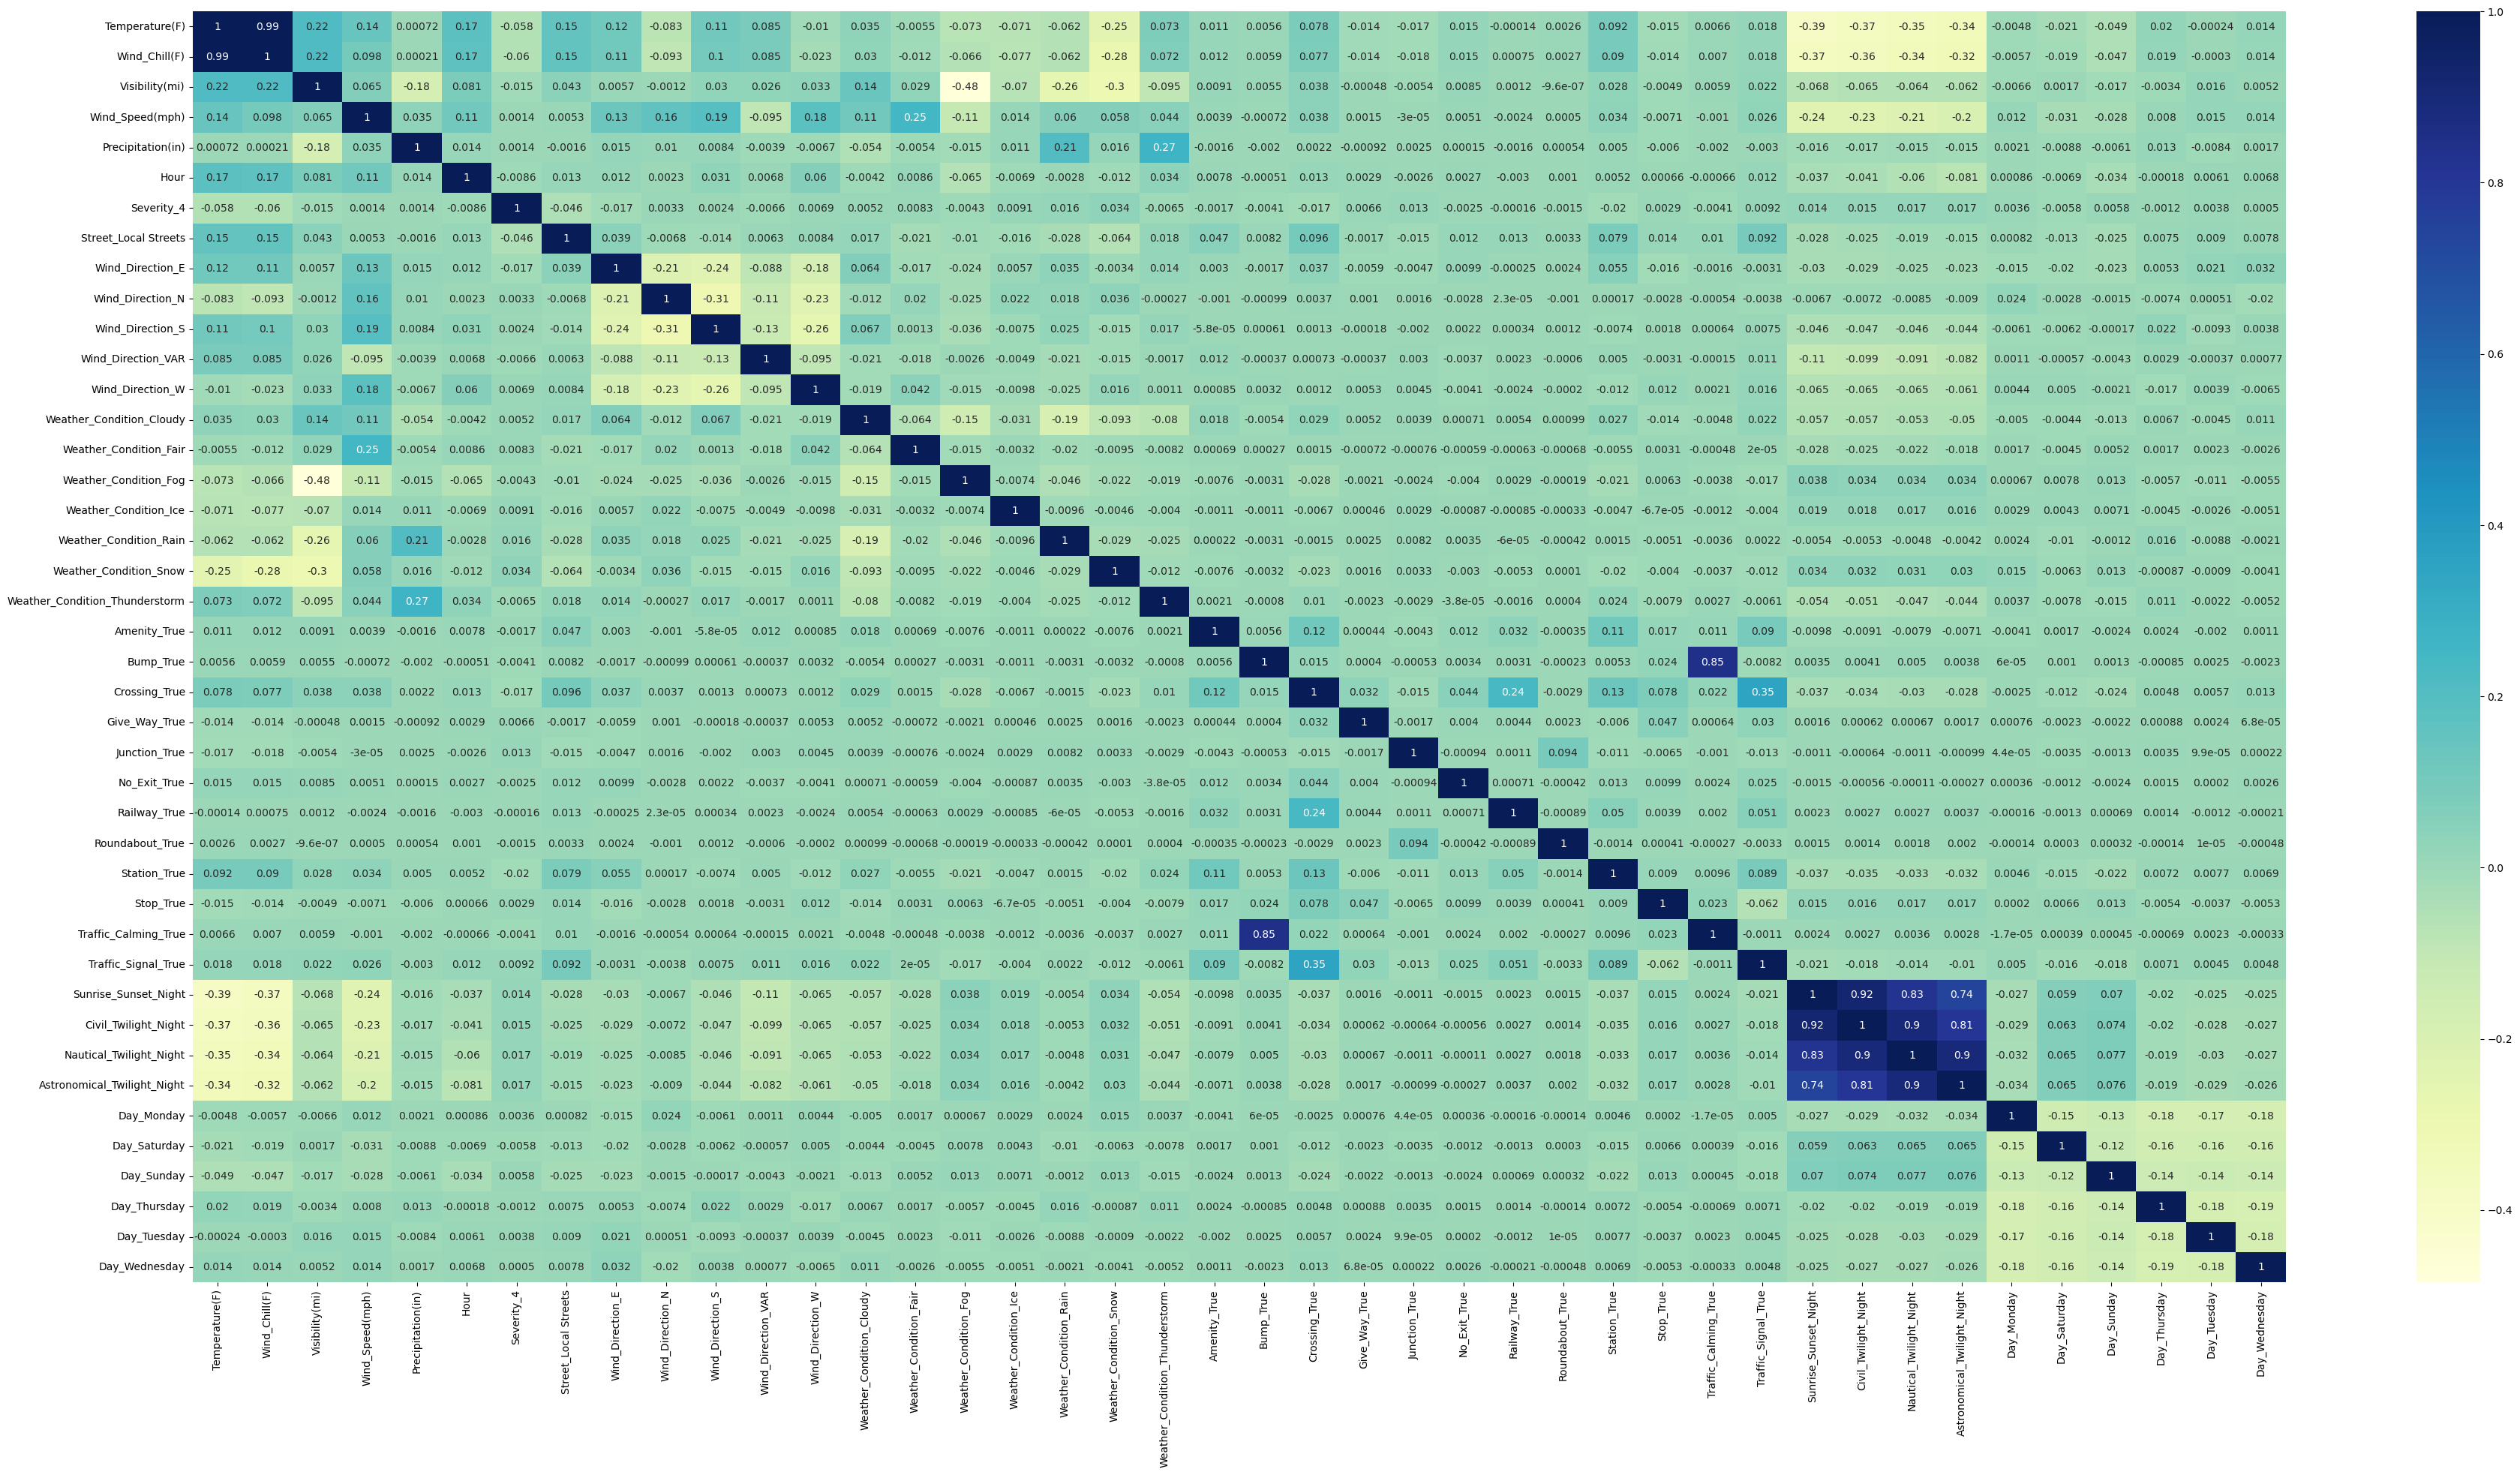

In [35]:
# show correlation of all values 
plt.figure(figsize=(45,22))
sns.heatmap(df_model.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [36]:
# target varaible 
y = df_model['Severity_4']
#X variables 
X = df_model.drop(['Severity_4'], axis = 1)

In [37]:
# to balance the data 
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Severity_4'])

# Check the numbers of  data to make sure balanced 
print("length of oversampled data is ",len(os_data_X))
print("Number of No Severe Accidents in oversampled data",len(os_data_y[os_data_y['Severity_4']==0]))
print("Number of Severe Accidents",len(os_data_y[os_data_y['Severity_4']==1]))
print("Proportion of No Severe Accidents in oversampled data is ",len(os_data_y[os_data_y['Severity_4']==0])/len(os_data_X))
print("Proportion of Severe Accidents in oversampled data is ",len(os_data_y[os_data_y['Severity_4']==1])/len(os_data_X))


length of oversampled data is  1279960
Number of No Severe Accidents in oversampled data 639980
Number of Severe Accidents 639980
Proportion of No Severe Accidents in oversampled data is  0.5
Proportion of Severe Accidents in oversampled data is  0.5


In [38]:
# to search for most valuable features 
df_vars=df_model.columns.values.tolist()
y=['Severity_4']
X=[i for i in df_vars if i not in y]


logreg = LogisticRegression()

# 42 total variables 
# select 35 variables important to model and then add them to an array, predictors 
rfe = RFE(logreg, n_features_to_select=30)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
predictors=[]
print('The following predictors are selected:')
for i in range(os_data_X.shape[1]):
    if rfe.support_[i] == True:
        predictors.append(os_data_X.columns[i])
        print('Column: %d, Rank: %.3f, Feature %s' % (i, rfe.ranking_[i], os_data_X.columns[i]))

The following predictors are selected:
Column: 0, Rank: 1.000, Feature Temperature(F)
Column: 1, Rank: 1.000, Feature Wind_Chill(F)
Column: 6, Rank: 1.000, Feature Street_Local Streets
Column: 7, Rank: 1.000, Feature Wind_Direction_E
Column: 8, Rank: 1.000, Feature Wind_Direction_N
Column: 9, Rank: 1.000, Feature Wind_Direction_S
Column: 10, Rank: 1.000, Feature Wind_Direction_VAR
Column: 11, Rank: 1.000, Feature Wind_Direction_W
Column: 12, Rank: 1.000, Feature Weather_Condition_Cloudy
Column: 13, Rank: 1.000, Feature Weather_Condition_Fair
Column: 14, Rank: 1.000, Feature Weather_Condition_Fog
Column: 15, Rank: 1.000, Feature Weather_Condition_Ice
Column: 16, Rank: 1.000, Feature Weather_Condition_Rain
Column: 17, Rank: 1.000, Feature Weather_Condition_Snow
Column: 18, Rank: 1.000, Feature Weather_Condition_Thunderstorm
Column: 19, Rank: 1.000, Feature Amenity_True
Column: 21, Rank: 1.000, Feature Crossing_True
Column: 23, Rank: 1.000, Feature Junction_True
Column: 24, Rank: 1.000, F

In [39]:
# Change X to most important columns 
# Add constant 
# Y is ReAdmis 
X = os_data_X[predictors]
y = os_data_y['Severity_4']

frames = [y, X]
df_model = pd.concat(frames, axis = 1)


# Analysis on Normalized Data

In [40]:
#normalize data. Range of 0 to 1 to help with analysis  
normalized_data = (df_model-df_model.min())/(df_model.max()-df_model.min())


# split X and y variables 
X = normalized_data.drop(['Severity_4'], axis=1)
y = normalized_data['Severity_4']
Xc = sm.add_constant(X,1)
normalized_data.head()

,Severity_4,Temperature(F),Wind_Chill(F),Street_Local Streets,Wind_Direction_E,Wind_Direction_N,Wind_Direction_S,Wind_Direction_VAR,Wind_Direction_W,Weather_Condition_Cloudy,...,Station_True,Stop_True,Traffic_Signal_True,Sunrise_Sunset_Night,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,0.0,0.399103,0.451943,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.466368,0.513292,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.439462,0.488753,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.426009,0.476483,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.502242,0.546012,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
# run model 
model = sm.Logit(y,Xc)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.453379
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             Severity_4   No. Observations:              1279960
Model:                          Logit   Df Residuals:                  1279929
Method:                           MLE   Df Model:                           30
Date:                Fri, 04 Nov 2022   Pseudo R-squ.:                  0.3459
Time:                        15:29:58   Log-Likelihood:            -5.8031e+05
converged:                       True   LL-Null:                   -8.8720e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              6.3637      0.022    290.961     

Correct predictions: 303141 (79%)
Incorrect predictions: 80847 (21%)


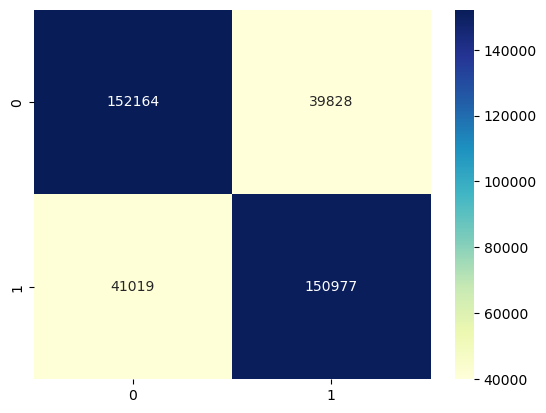

In [42]:
# Run a test against the predicted outcome versus true outcome 
X_train, X_test, y_train, y_test = train_test_split(Xc, y, test_size=0.3, random_state=0)
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
predicted = lgr.predict(X_test)
expected = y_test 

# Confusion matrix to show accuracy of test 
matrix = pd.DataFrame(confusion_matrix(y_true=expected, y_pred=predicted),
                     index=range(2), columns=range(2))
axes = sns.heatmap(matrix, annot=True, cmap='YlGnBu', fmt='g')


correct = sum(np.diagonal(matrix))
total = matrix.values.sum()
incorrect = total - correct 

print('Correct predictions: {} ({:.0%})'.format(correct, correct/total))
print('Incorrect predictions: {} ({:.0%})'.format(incorrect, incorrect/total))

In [43]:
# Classification report to show accuracy of model 
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79    191992
         1.0       0.79      0.79      0.79    191996

    accuracy                           0.79    383988
   macro avg       0.79      0.79      0.79    383988
weighted avg       0.79      0.79      0.79    383988



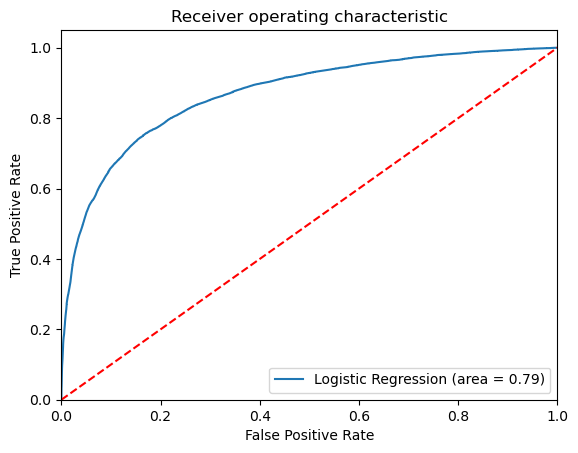

In [44]:
# ROC to show accuracy of model 
logit_roc_auc = roc_auc_score(y_test, lgr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lgr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()